# The full tutorial on `SingleCellArchetype`
- To start **↓↓↓**  
- [![Open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FangmingXie/SingleCellArchetype/blob/main/sca/tutorial_complete.ipynb)
- Expected time: ~ 10 min.

# setting up

In [1]:
# installing prerequisite packages (only if in Google Colab)
try:
    import google.colab
    print("Running in Google Colab")
    print("Installing prerequisite packages... (expected time < 1 min)")
    
    !pip install anndata
    !pip install py_pcha
    !wget https://raw.githubusercontent.com/FangmingXie/SingleCellArchetype/refs/heads/main/sca/sca.py
    !wget https://raw.githubusercontent.com/FangmingXie/SingleCellArchetype/refs/heads/main/sca/utils.py
    
except ImportError:
    print("Not running in Google Colab")
    print("Skip installing prerequisite packages.")

Not running in Google Colab
Skip installing prerequisite packages.


In [2]:
# import packages  
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')

import anndata as ad 

from sca import SingleCellArchetype
from utils import plot_archetype

In [3]:
# load sample data
file_name = 'data_snrna_v1.h5ad'
if not os.path.isfile(file_name):
    !wget 'https://raw.githubusercontent.com/FangmingXie/SingleCellArchetype/main/data/data_snrna_v1.h5ad'
    
adata = ad.read_h5ad(file_name)
adata

AnnData object with n_obs × n_vars = 4044 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'
    layers: 'lognorm', 'norm'

In [4]:
# set up SingleCellArchetype object using the sample data 
x = np.array(adata.X.todense())
depths = adata.obs['n_counts'].values
types = adata.obs['Type'].values

sca = SingleCellArchetype(x, depths, types)

# Run SingleCellArchetype with different controls
In the example below, we will run `SingleCellArchetype` in different modes.

- First, we can infer archetypes using the original data. 
- To assess the **stability** of archetypal inference, we downsample cells (or genes) and repeat the inference.
- To assess the **statistical significance of the archetypal fit**, we **shuffle the data** and compare the shuffled results with data. The effect can be directly visualized, and quantified using t-ratio test. 
- To assess the **significance of the transcriptomic continuum**, we shuffle the data **locally within each cell type (or cluster)**. The effect can be directly visualzed (and later quantified). 

In [5]:
ndim = 2
noc = 3
sca.setup_feature_matrix(method='data')
xp, aa = sca.proj_and_pcha(ndim, noc)

nrepeats = 3
p = 0.8
aa_dsamps = sca.downsamp_proj_pcha(ndim, noc, nrepeats=nrepeats, p=p)

use data


In [6]:
# gshuff
sca.setup_feature_matrix(method='gshuff')
xp_gshuff, aa_gshuff = sca.proj_and_pcha(ndim, noc)
aa_gshuff_dsamps = sca.downsamp_proj_pcha(ndim, noc, nrepeats=nrepeats, p=p)

use shuffled data


In [7]:
# tshuff 
sca.setup_feature_matrix(method='tshuff')
xp_tshuff, aa_tshuff = sca.proj_and_pcha(ndim, noc)
aa_tshuff_dsamps = sca.downsamp_proj_pcha(ndim, noc, nrepeats=nrepeats, p=p)

use per-type shuffled data


# plot

In [8]:
types_colorvec = np.char.add('C', sca.types_idx.astype(str))

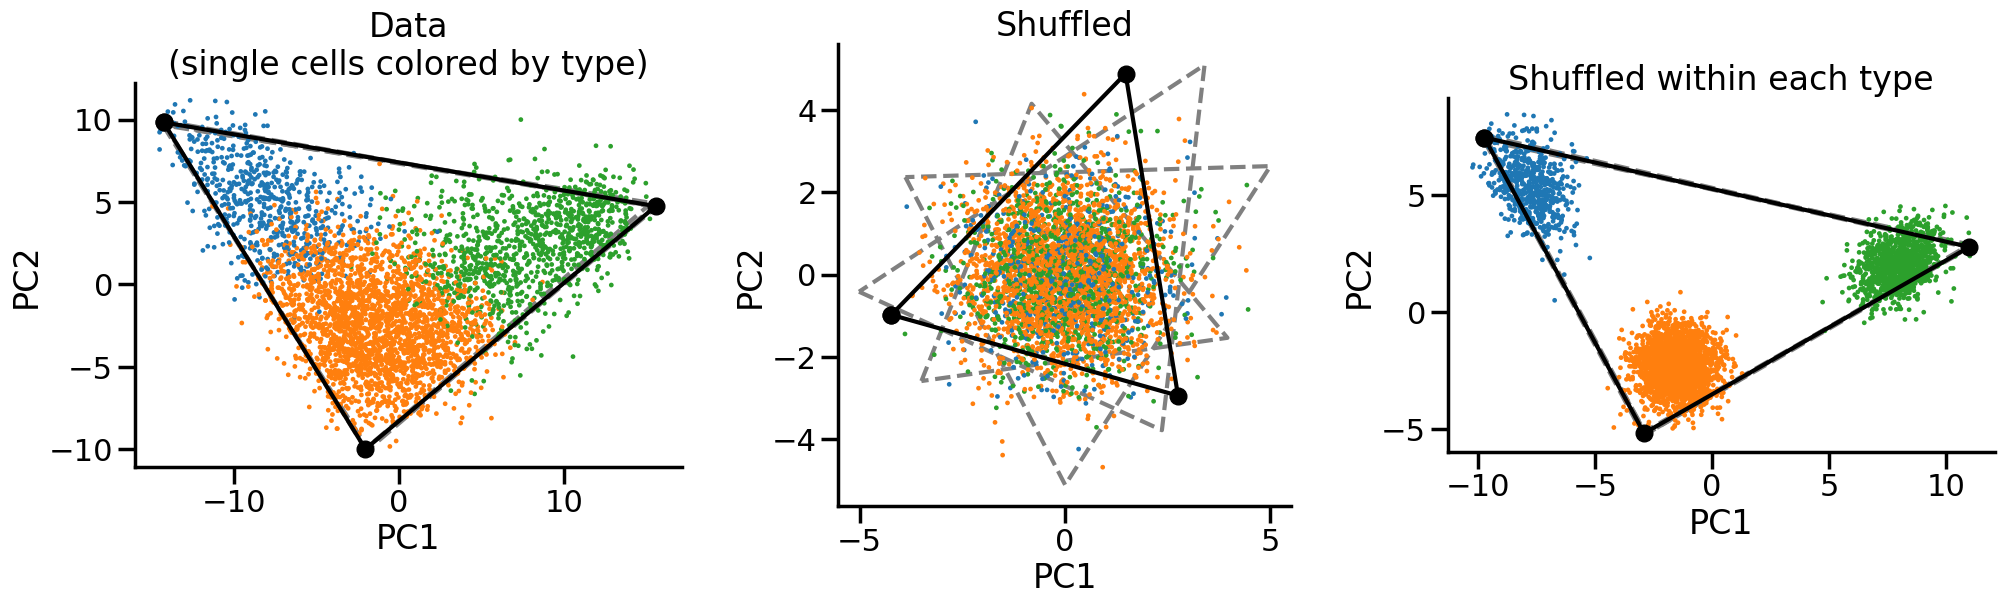

In [9]:
# plot
fig, axs = plt.subplots(1,3,figsize=(8*3,6))
ax = axs[0]
ax.scatter(xp[:,0], xp[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa, fmt='-o', color='k', zorder=2)
for i in range(nrepeats):
    plot_archetype(ax, aa_dsamps[i], fmt='--', color='gray', zorder=0)
ax.set_title('Data\n(single cells colored by type)')
    
ax = axs[1]
ax.set_title('Shuffled')
ax.scatter(xp_gshuff[:,0], xp_gshuff[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa_gshuff, fmt='-o', color='k', zorder=2)
for i in range(nrepeats):
    plot_archetype(ax, aa_gshuff_dsamps[i], fmt='--', color='gray', zorder=0)

ax = axs[2]
ax.set_title('Shuffled within each type')
ax.scatter(xp_tshuff[:,0], xp_tshuff[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa_tshuff, fmt='-o', color='k', zorder=2)
for i in range(nrepeats):
    plot_archetype(ax, aa_tshuff_dsamps[i], fmt='--', color='gray', zorder=0)

for i in range(3):
    ax = axs[i]
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_aspect('equal')
    sns.despine(ax=ax)
    ax.grid(False)
    
plt.show()

# quantify t-ratio 

- for 2-dimensional data only

In [ ]:
t_ratio, t_ratio_shuffs, pval = sca.t_ratio_test(ndim, noc, nrepeats=20)
print(f'p-value: {pval}')

use data
use shuffled data
use shuffled data
use shuffled data
use shuffled data


In [ ]:
fig, ax = plt.subplots()
ax.axvline(t_ratio, color='r', label='data')
sns.histplot(t_ratio_shuffs, ax=ax, stat='density', label='shuffled')
ax.set_xlabel('t-ratio')
ax.legend()
sns.despine(ax=ax)
plt.show()

# quantify stability

In [ ]:
from sklearn.metrics import pairwise_distances

In [ ]:
def get_relative_variation(aa_list):
    """
    """
    
    aa_avg = np.mean(aa_list, axis=0).T
    ref = np.mean(pairwise_distances(aa_avg))

    aa_std = np.std(aa_list, axis=0).T
    epsilon = np.mean(np.sqrt(np.sum(np.power(aa_std,2), axis=1)))
    
    return epsilon/ref

In [ ]:
var_data   = get_relative_variation(aa_dsamps)
var_gshuff = get_relative_variation(aa_gshuff_dsamps)

In [ ]:
fig, ax = plt.subplots(figsize=(3,6))
ax.bar(np.arange(2), [var_data, var_gshuff])
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['data', 'shuffled'], rotation=90)
ax.set_ylabel('Archetype variation\n(higher being less stable)')
plt.show()